In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [4]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

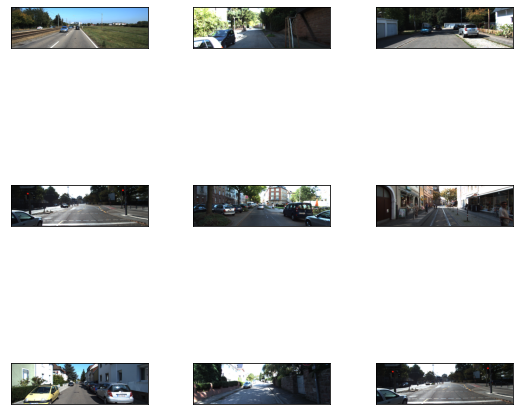

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

- 데이터셋 개수: (train=6347, test=711, valid=423)
- 라벨: alpha, bbox, dimensions, location, occluded, rotation_y, truncated

In [7]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.64, -1.73, -1.27,  1.92,  1.77,  1.7 , -1.5 ,  1.66],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[0.17676471, 0.49588853, 0.56914437, 0.54193056],
       [0.19227272, 0.54339254, 0.59090906, 0.5897011 ],
       [0.14858289, 0.19015348, 0.576631  , 0.23835218],
       [0.0026738 , 0.19573505, 0.5806417 , 0.30926496],
       [0.26671124, 0.3434895 , 0.55326205, 0.3988126 ],
       [0.3351337 , 0.35854605, 0.5575668 , 0.39002424],
       [0.38852942, 0.5875929 , 0.5652674 , 0.60132474],
       [0.45256683, 0.38852182, 0.553369  , 0.4220517 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[1.73, 0.84, 0.86],
       [1.81, 0.9 , 0.95],
       [1.78, 0.92, 1.01],
       [1.81, 0.65, 1.7 ],
       [1.7 , 0.81, 1.72],
       [1.79, 0.62, 1.9 ],
       [1.63, 0.61, 0.82],
       [2.11

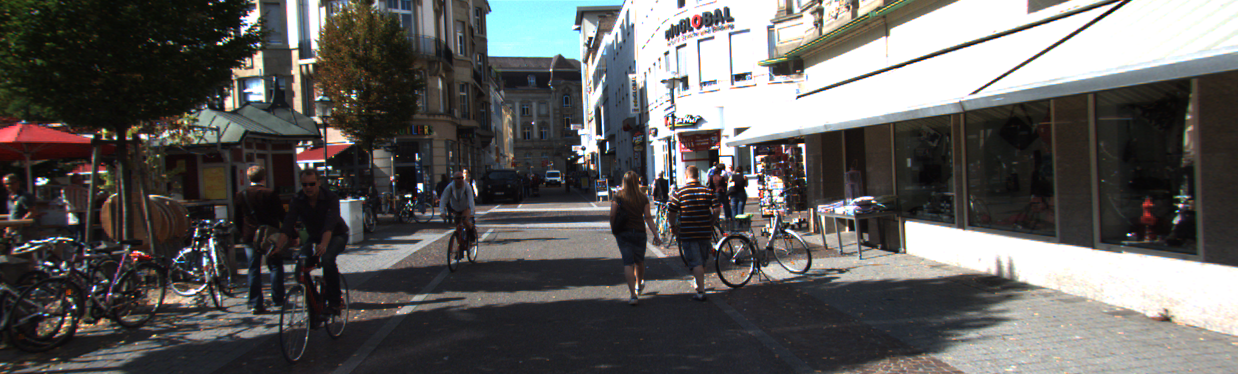

In [8]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

In [9]:
'''
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
'''

"\n데이터셋 이해를 위한 예시\nValues    Name      Description\n----------------------------------------------------------------------------\n   1    type         Describes the type of object: 'Car', 'Van', 'Truck',\n                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',\n                     'Misc' or 'DontCare'\n   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where\n                     truncated refers to the object leaving image boundaries\n   1    occluded     Integer (0,1,2,3) indicating occlusion state:\n                     0 = fully visible, 1 = partly occluded\n                     2 = largely occluded, 3 = unknown\n   1    alpha        Observation angle of object, ranging [-pi..pi]\n   4    bbox         2D bounding box of object in the image (0-based index):\n                     contains left, top, right, bottom pixel coordinates\n   3    dimensions   3D object dimensions: height, width, length (in meters)\n   3    location     3D object location x,

1238 374
(8, 4)


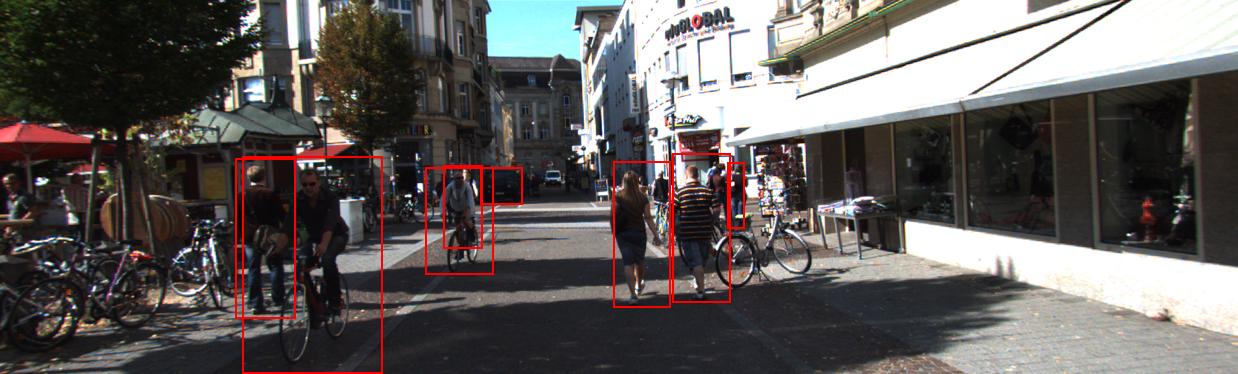

In [10]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 클래스 및 바운딩 박스 정보 추출

In [11]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df
    
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:03<00:00,  8.78it/s]


In [12]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:20<00:00,  8.88it/s]


In [13]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

In [14]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2020-10-21 18:33:02.850204: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 18:33:03.940968: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-21 18:33:03.945149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-21 18:33:03.945461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-21 18:33:03.945477: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 18:33:03.947350: I tensorflow/stream_executor/platform

bn4a_branch2b (BatchNormalizati (None, None, None, 2 1024        res4a_branch2b[0][0]             
__________________________________________________________________________________________________
res4a_branch2b_relu (Activation (None, None, None, 2 0           bn4a_branch2b[0][0]              
__________________________________________________________________________________________________
res4a_branch2c (Conv2D)         (None, None, None, 1 262144      res4a_branch2b_relu[0][0]        
__________________________________________________________________________________________________
res4a_branch1 (Conv2D)          (None, None, None, 1 524288      res3d_relu[0][0]                 
__________________________________________________________________________________________________
bn4a_branch2c (BatchNormalizati (None, None, None, 1 4096        res4a_branch2c[0][0]             
__________________________________________________________________________________________________
bn4a_branc

Epoch 1/50
2020-10-21 18:33:12.890416: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-10-21 18:33:13.962861: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2020-10-21 18:33:14.009232: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2020-10-21 18:33:14.377990: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-10-21 18:33:23.732984: I tensorflow/stream_executor/cuda/cuda_driver.cc:775] failed to allocate 2.29G (2457061120 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-21 18:33:23.733012: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying

195/195 [==============================] - ETA: 0s - loss: 1.7890 - regression_loss: 1.4324 - classification_loss: 0.3565
Epoch 00007: saving model to ./snapshots/resnet50_csv_07.h5
195/195 [==============================] - 65s 333ms/step - loss: 1.7890 - regression_loss: 1.4324 - classification_loss: 0.3565
Epoch 8/50
195/195 [==============================] - ETA: 0s - loss: 1.7777 - regression_loss: 1.3869 - classification_loss: 0.3909
Epoch 00008: saving model to ./snapshots/resnet50_csv_08.h5
195/195 [==============================] - 60s 310ms/step - loss: 1.7777 - regression_loss: 1.3869 - classification_loss: 0.3909
Epoch 9/50
195/195 [==============================] - ETA: 0s - loss: 1.6289 - regression_loss: 1.2868 - classification_loss: 0.3421
Epoch 00009: saving model to ./snapshots/resnet50_csv_09.h5
195/195 [==============================] - 60s 310ms/step - loss: 1.6289 - regression_loss: 1.2868 - classification_loss: 0.3421
Epoch 10/50
195/195 [========================

Epoch 24/50
195/195 [==============================] - ETA: 0s - loss: 1.0783 - regression_loss: 0.8225 - classification_loss: 0.2558
Epoch 00024: saving model to ./snapshots/resnet50_csv_24.h5
195/195 [==============================] - 60s 310ms/step - loss: 1.0783 - regression_loss: 0.8225 - classification_loss: 0.2558
Epoch 25/50
195/195 [==============================] - ETA: 0s - loss: 1.0419 - regression_loss: 0.7589 - classification_loss: 0.2830
Epoch 00025: saving model to ./snapshots/resnet50_csv_25.h5
195/195 [==============================] - 60s 310ms/step - loss: 1.0419 - regression_loss: 0.7589 - classification_loss: 0.2830
Epoch 26/50
195/195 [==============================] - ETA: 0s - loss: 1.0504 - regression_loss: 0.8029 - classification_loss: 0.2475
Epoch 00026: saving model to ./snapshots/resnet50_csv_26.h5
195/195 [==============================] - 60s 310ms/step - loss: 1.0504 - regression_loss: 0.8029 - classification_loss: 0.2475
Epoch 27/50
195/195 [==========

195/195 [==============================] - ETA: 0s - loss: 1.0221 - regression_loss: 0.7682 - classification_loss: 0.2538
Epoch 00040: saving model to ./snapshots/resnet50_csv_40.h5

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
195/195 [==============================] - 60s 310ms/step - loss: 1.0221 - regression_loss: 0.7682 - classification_loss: 0.2538
Epoch 41/50
195/195 [==============================] - ETA: 0s - loss: 1.0397 - regression_loss: 0.7716 - classification_loss: 0.2682
Epoch 00041: saving model to ./snapshots/resnet50_csv_41.h5
195/195 [==============================] - 60s 310ms/step - loss: 1.0397 - regression_loss: 0.7716 - classification_loss: 0.2682
Epoch 42/50
195/195 [==============================] - ETA: 0s - loss: 0.9914 - regression_loss: 0.7426 - classification_loss: 0.2488
Epoch 00042: saving model to ./snapshots/resnet50_csv_42.h5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
195/195 [==

In [15]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_10.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-10-21 19:25:50.836318: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 19:25:52.177564: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-21 19:25:52.181878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-21 19:25:52.182197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-21 19:25:52.182211: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 19:25:52.185364: I tensorflow/stream_executor/platform

In [16]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[589.87885 173.91165 626.238   206.20534]


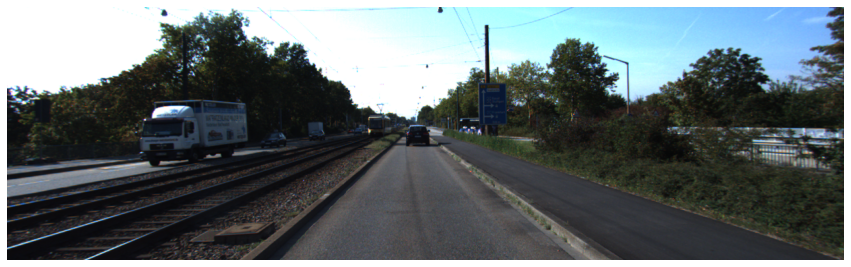

In [19]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[625.46875 177.11209 670.819   213.66127]
[607.8586  167.11322 667.9541  210.38992]


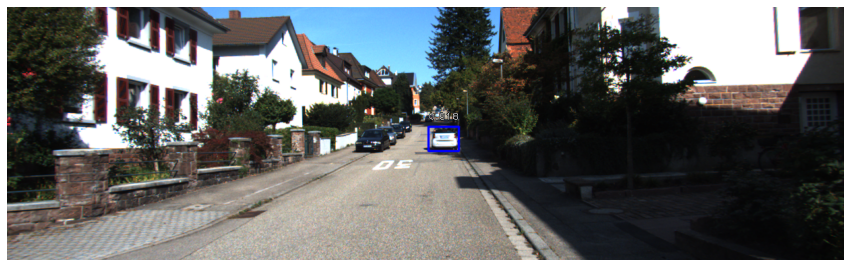

In [50]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_2.png'
inference_on_image(model, img_path=img_path)

In [52]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if label == 1:
            return "Stop"
        
        elif label == 0:
            width = box[2] - box[0]
            height = box[3] - box[1]
            
            if width > 300 or height > 300:
                return "Stop"
            
        if score < 0.5:
            return "Go"

print(self_drive_assist(img_path)) 

Stop


In [55]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.
